# 2D Toy Example
Author: Mila Gorecki

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sbi import utils as utils
# from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils import plot

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (4, 3)

#### Define prior and Simulator

In [4]:
prior_2d = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros(2), covariance_matrix = torch.tensor([[3.,1.],[1.,1.]]))

def linear_gaussian(theta):
    # returns sample of p(x|theta): mean 0.5*theta+2, 3 std
    return 0.5*theta + 2 + torch.randn_like(theta) * 3

/Users/mgorecki/.virtualenvs/sbi_venv2/lib/python3.7/site-packages/pyro/distributions/torch_patch.py:82: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  for v in flattened_value]).view(batch_shape)


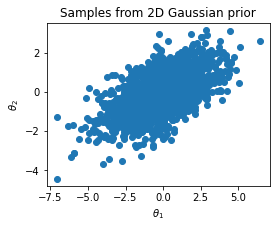

In [5]:
samples_prior = prior_2d.sample((2000,)).numpy()
plt.scatter(samples_prior[:,0], samples_prior[:,1])
plt.title('Samples from 2D Gaussian prior')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.show()

#### Posterior Estimation with sbi

In [6]:
num_sim = 2000

simulator_2d, prior_2d = prepare_for_sbi(linear_gaussian, prior_2d)
inference = SNPE(prior=prior_2d)
sim_thetas, sim_xs = simulate_for_sbi(simulator_2d, proposal=prior_2d, num_simulations=num_sim)
inference = inference.append_simulations(sim_thetas, sim_xs)
density_estimator = inference.train()
posterior_sbi = inference.build_posterior(density_estimator)

Running 2000 simulations.: 100%|██████████| 2000/2000 [00:00<00:00, 20652.85it/s]


Neural network successfully converged after 32 epochs.


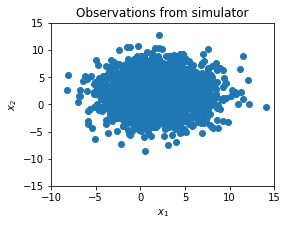

In [7]:
plt.title('Observations from simulator')
plt.xlabel(r'$x_1$'); plt.ylabel(r'$x_2$')
plt.scatter(sim_xs[:,0], sim_xs[:,1])
plt.xlim(-10,15)
plt.ylim(-15,15)
plt.show()

#### Sample from prosterior over range

1. Define a range
2. Sample from posterior over observations range
    - rejection sampling in observation space $x_i\sim p(x_0<x<x_1)$
    - sample from individual posteriors $p(\theta|x_i)$

In [8]:
x_range = torch.tensor([[0, -15],[5, 15]])

In [9]:
acc_obs, samples = posterior_sbi.sample_range(x_range, sim_xs, (5000,))

1147 accepted observations x_i, sampling 5 from each individual posterior p(theta|x_i).


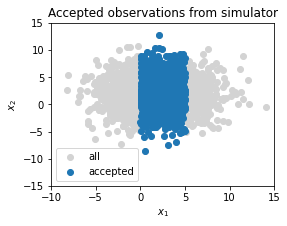

In [10]:
plt.title('Accepted observations from simulator')
plt.xlabel(r'$x_1$'); plt.ylabel(r'$x_2$')
plt.scatter(sim_xs[:,0], sim_xs[:,1], color='lightgray', label='all')
plt.scatter(acc_obs[:,0], acc_obs[:,1], color='#1f77b4', label='accepted')
plt.xlim(-10,15); plt.ylim(-15,15)
plt.legend()
plt.show()


8 accepted observations x_i, sampling 626 from each individual posterior p(theta|x_i).


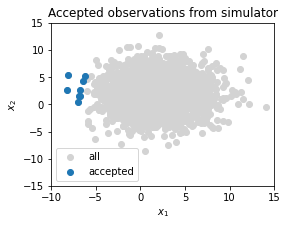

In [11]:
x_range2 = torch.tensor([[-10, -15],[-6, 15]])
acc_obs2, samples2 = posterior_sbi.sample_range(x_range2, sim_xs, (5000,))

plt.title('Accepted observations from simulator')
plt.xlabel(r'$x_1$'); plt.ylabel(r'$x_2$')
plt.scatter(sim_xs[:,0], sim_xs[:,1], color='lightgray', label='all')
plt.scatter(acc_obs2[:,0], acc_obs2[:,1], color='#1f77b4', label='accepted')
plt.xlim(-10,15); plt.ylim(-15,15)
plt.legend()
plt.show()

Visualize resulting samples from posterior over ranges

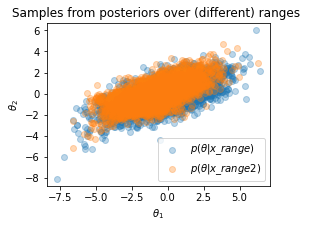

In [12]:
plt.title('Samples from posteriors over (different) ranges '); 
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$')
#plt.scatter(sim_thetas[:,0], sim_thetas[:,1], alpha=0.3, label="simulated")
plt.scatter(samples[:,0], samples[:,1], alpha=0.3, label=r"$p(\theta|x\_range)$")
plt.scatter(samples2[:,0], samples2[:,1], alpha=0.3, label=r"$p(\theta|x\_range2)$")
plt.legend()
plt.show()

Look at posterior predictives, i.e. simulate with parameters from $p(\theta|x_0<x<x_1)$

In [13]:
x_gen = torch.stack([linear_gaussian(s) for s in samples])
x_gen2 = torch.stack([linear_gaussian(s) for s in samples2])

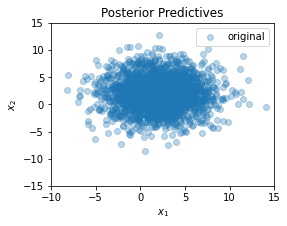

In [14]:
plt.title(r'Posterior Predictives'); 
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(sim_xs[:,0], sim_xs[:,1], alpha=0.3, label="original")
#plt.scatter(x_gen[:,0], x_gen[:,1], alpha=0.3, label="post. pred.")
#plt.scatter(x_gen2[:,0], x_gen2[:,1], alpha=0.3, label="2")
plt.legend()
plt.xlim(-10,15)
plt.ylim(-15,15)
plt.show()

#### Test Density Estimator

No context provided, use uncondintional MAF.
Train density estimator.
epoch | _val_log_prob | best val_log_prob


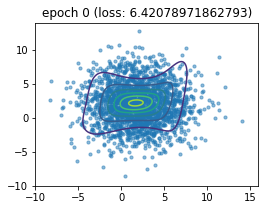

    1 |        -6.494 |            -6.494
    2 |        -5.649 |            -5.649
    3 |        -5.287 |            -5.287
    4 |        -5.155 |            -5.155
    5 |        -5.184 |            -5.155
    6 |        -5.128 |            -5.128
    7 |        -5.122 |            -5.122
    8 |        -5.118 |            -5.118
    9 |        -5.117 |            -5.117
   10 |         -5.12 |            -5.117


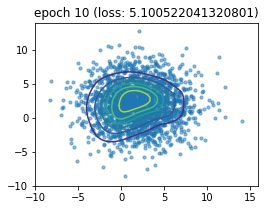

   11 |        -5.155 |            -5.117
   12 |        -5.143 |            -5.117
   13 |        -5.113 |            -5.113
   14 |        -5.135 |            -5.113
   15 |        -5.103 |            -5.103
   16 |        -5.161 |            -5.103
   17 |        -5.091 |            -5.091
   18 |        -5.101 |            -5.091
   19 |        -5.105 |            -5.091
   20 |        -5.105 |            -5.091


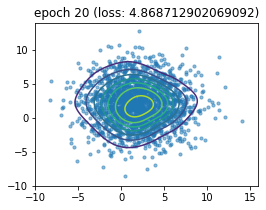

   21 |        -5.147 |            -5.091
   22 |        -5.145 |            -5.091
   23 |        -5.127 |            -5.091
   24 |        -5.135 |            -5.091
   25 |          -5.1 |            -5.091
   26 |        -5.107 |            -5.091
   27 |        -5.093 |            -5.091
   28 |        -5.137 |            -5.091
   29 |        -5.158 |            -5.091
   30 |        -5.102 |            -5.091


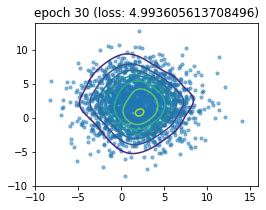

   31 |        -5.163 |            -5.091
   32 |        -5.152 |            -5.091
   33 |        -5.144 |            -5.091
   34 |        -5.106 |            -5.091
   35 |        -5.117 |            -5.091
   36 |        -5.099 |            -5.091
   37 |        -5.116 |            -5.091
Converged after 37 epochs.
Sample from estimated density.
Sampled 5000, accepted 2875.
Sampled 5000, accepted 2862.
5737 accepted observations x_i, sampling 1 from each individual posterior p(theta|x_i).


In [15]:
acc_obs_de, samples_de = posterior_sbi.sample_range(x_range, sim_xs, (5000,), train_px=True, visualize_training=10)

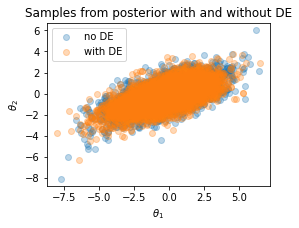

In [16]:
plt.title('Samples from posterior with and without DE'); 
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$')
plt.scatter(samples[:,0], samples[:,1], alpha=0.3, label="no DE")
plt.scatter(samples_de[:,0], samples_de[:,1], alpha=0.3, label="with DE")
plt.legend()
plt.show()